In [1]:
import numpy
import scipy

from metricdiversity.acquisitions.cas import ConstraintActiveSearchService
from metricdiversity.acquisitions.expected_metric_coverage import ExpectedMetricCoverageService
from metricdiversity.acquisitions.mobo import MOBOService

from metricdiversity.utilities.sigopt_colors import *

import matplotlib.pyplot as plt
%matplotlib inline

## 2D test function

In [2]:
# define objective 
def f_1(x, scale_x=1):
  return numpy.exp(-0.5* ((x[0]-0.2)**2 + scale_x * (x[1]-0.5)**2))

def f_2(x, scale_y=1):
  return numpy.exp(-0.5* ((x[0]-0.8)**2 + scale_y *(x[1]-0.5)**2))

def two_humps_unscaled(x):
  return [f_1(x), f_2(x)]

def two_humps_scaled(x):
  return [f_1(x, 4), f_2(x, 4)]

In [3]:
def ellipse_points(center, radius_x, radius_y, angle_rad=0):
  assert len(center) == 2
  num_points = 1000
  theta = numpy.linspace(0, 2 * numpy.pi, num_points)
  xs = radius_x * numpy.cos(theta) 
  ys = radius_y * numpy.sin(theta)
  if angle_rad != 0:
    rot_mat = numpy.array([
      [numpy.cos(angle_rad), -numpy.sin(angle_rad)],
      [numpy.sin(angle_rad), numpy.cos(angle_rad)],
    ])
    rotated = numpy.dot(rot_mat, numpy.array([xs, ys]))
    xs = rotated[0]
    ys = rotated[1]
    
  return xs + center[0], ys + center[1]

threshold = 0.85
radius = numpy.sqrt(-2 * numpy.log(threshold))
print(radius)
x_c1, y_c1 = ellipse_points([0.2, 0.5], radius, radius)
x_c2, y_c2 = ellipse_points([0.8, 0.5], radius, radius)
x_ell1, y_ell1 = ellipse_points([0.2, 0.5], radius, radius / 2)
x_ell2, y_ell2 = ellipse_points([0.8, 0.5], radius, radius / 2)


x_0 = numpy.linspace(0.2+radius, 0.8-radius, 100)
x_1 = numpy.ones(100) * 0.5
xxx = numpy.vstack((x_0, x_1)).T
y_0 = numpy.array([f_1(xx) for xx in xxx])
y_1 = numpy.array([f_2(xx) for xx in xxx])
yyy = numpy.vstack((y_0, y_1)).T

x_c1_p = x_c1[x_c1>=0.5]
y_c1_p = y_c1[x_c1>=0.5]
x_c2_p = x_c2[x_c2<=0.5]
y_c2_p = y_c2[x_c2<=0.5]
sorted_idx = numpy.argsort(y_c1_p)

0.5701209161182826


In [4]:
parameters = [
  {'name': 'x0', 'type': 'double', 'bounds': {'min': 0, 'max': 1}},
  {'name': 'x1', 'type': 'double', 'bounds': {'min': 0, 'max': 1}}
]
param_names = ['x0', 'x1']
threshold = 0.85
constraints = [("gt", threshold)] * 2

def objective_function(suggestion):
  print("suggestions:", suggestion)
  pt = numpy.array([suggestion[p] for p in param_names])
  values = two_humps_unscaled(pt)
  print("obj:", values)
  return values

In [5]:
cas = ConstraintActiveSearchService(
  parameters=parameters,
  constraints=constraints,
  punchout_radius=0.1,
  num_init_points=6,
)

In [6]:
for i in range(20):
  suggestion = cas.create_suggestion()
  values = objective_function(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  cas.create_observation(observation)

suggestions: {'id': 6, 'x0': 0.17257177829742432, 'x1': 0.8102609515190125}
obj: [0.9526505919515716, 0.7827327038132316]
suggestions: {'id': 5, 'x0': 0.980158269405365, 'x1': 0.23758605122566223}
obj: [0.7126577392532936, 0.9506027315805822]
suggestions: {'id': 4, 'x0': 0.8266047239303589, 'x1': 0.8751835227012634}
obj: [0.7659042800046912, 0.9317085353472568]
suggestions: {'id': 3, 'x0': 0.020909473299980164, 'x1': 0.07695328444242477}
obj: [0.8998556025429796, 0.6750454303387465]
suggestions: {'id': 2, 'x0': 0.35716867446899414, 'x1': 0.6267932057380676}
obj: [0.9798172006867778, 0.8993454572702567]
suggestions: {'id': 1, 'x0': 0.5533662438392639, 'x1': 0.32731199264526367}
obj: [0.9255710088275496, 0.955687140119421]
 >>> x_next tensor([[0.5232, 0.5243]], dtype=torch.float64) eci tensor(0.9733, dtype=torch.float64)
suggestions: {'id': 7, 'x0': 0.5232451733202835, 'x1': 0.5242973224933991}
obj: [0.9488174104130429, 0.9621433788241217]
 >>> x_next tensor([[0.5251, 0.7324]], dtype=tor

In [7]:
cas_points = numpy.array(cas.get_points())
cas_values = numpy.array(cas.get_values())
cas_feasible_inds = numpy.array(cas.get_feasible_indices())

In [8]:
hypers = numpy.array([[0.01, 0.3, 0.3], [0.01, 0.3, 0.3]])
emcs = ExpectedMetricCoverageService(
  parameters=parameters,
  constraints=constraints,
  punchout_radius=0.03,
  num_init_points=6,
  hyperparameters=hypers,
  verbose=False,
)

In [9]:
for i in range(20):
  suggestion = emcs.create_suggestion()
  values = objective_function(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  emcs.create_observation(observation)

suggestions: {'id': 6, 'x0': 0.5304204018320888, 'x1': 0.7111559929326177}
obj: [0.9259988857326826, 0.9430556290210373]
suggestions: {'id': 5, 'x0': 0.08253811439499259, 'x1': 0.009450368583202362}
obj: [0.8805415899199005, 0.6854393571078128]
suggestions: {'id': 4, 'x0': 0.814593292074278, 'x1': 0.8498068205080926}
obj: [0.7787658443845067, 0.9405514865586347]
suggestions: {'id': 3, 'x0': 0.25930368807166815, 'x1': 0.4293513153679669}
obj: [0.9957549537598506, 0.8618518686610317]
suggestions: {'id': 2, 'x0': 0.6432980676181614, 'x1': 0.18741132388822734}
obj: [0.863196923944424, 0.9406975654541236]
suggestions: {'id': 1, 'x0': 0.21203188668005168, 'x1': 0.607898181071505}
obj: [0.9941239400814174, 0.836378296996227]
suggestions: {'id': 7, 'x0': 0.3985330638010055, 'x1': 0.5812678091228008}
obj: [0.9772527922008867, 0.9195323266090335]
suggestions: {'id': 8, 'x0': 0.4720834041945636, 'x1': 0.15020928243175147}
obj: [0.9064753311344976, 0.8914183617088709]
suggestions: {'id': 9, 'x0': 

In [10]:
emcs_points = numpy.array(emcs.get_points())
emcs_values = numpy.array(emcs.get_values())
emcs_feasible_inds = numpy.array(emcs.get_feasible_indices())

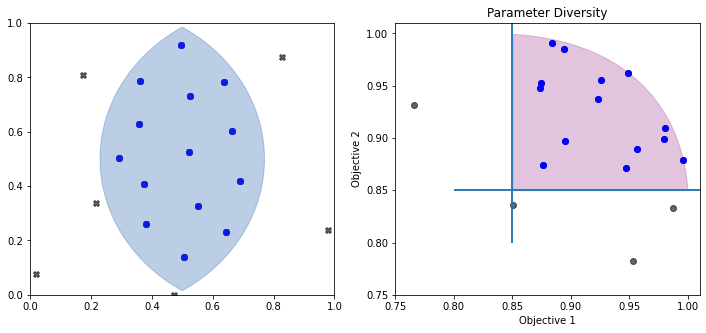

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(cas_points[:, 0], cas_points[:, 1], marker='X', color='black', alpha=0.6)
axes[0].scatter(cas_points[cas_feasible_inds, 0], cas_points[cas_feasible_inds, 1], marker='o', color='blue')
axes[0].fill(
  numpy.append(x_c1_p[sorted_idx], x_c2_p),
  numpy.append(y_c1_p[sorted_idx], y_c2_p),
  color=sigopt_blue, 
  alpha=0.3
)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
axes[1].scatter(cas_values[:, 0], cas_values[:, 1], color="black", alpha=0.6)
axes[1].scatter(cas_values[cas_feasible_inds, 0], cas_values[cas_feasible_inds, 1], marker='o', color='blue')
axes[1].vlines([threshold] * 2, 0.8, 1.01)
axes[1].hlines([threshold] * 2, 0.8, 1.01)
axes[1].set_xlim([0.75, 1.01])
axes[1].set_ylim([0.75, 1.01])
plt.title("Parameter Diversity")
plt.show()

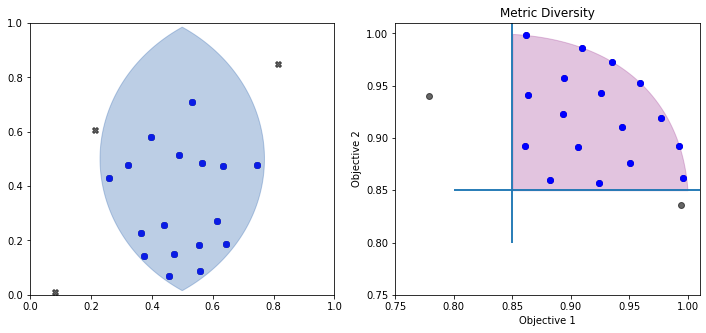

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(emcs_points[:, 0], emcs_points[:, 1], marker='X', color='black', alpha=0.6)
axes[0].scatter(emcs_points[emcs_feasible_inds, 0], emcs_points[emcs_feasible_inds, 1], marker='o', color='blue')
axes[0].fill(
  numpy.append(x_c1_p[sorted_idx], x_c2_p),
  numpy.append(y_c1_p[sorted_idx], y_c2_p),
  color=sigopt_blue, 
  alpha=0.3
)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
axes[1].scatter(emcs_values[:, 0], emcs_values[:, 1], color="black", alpha=0.6)
axes[1].scatter(emcs_values[emcs_feasible_inds, 0], emcs_values[emcs_feasible_inds, 1], marker='o', color='blue')
axes[1].vlines([threshold] * 2, 0.8, 1.01)
axes[1].hlines([threshold] * 2, 0.8, 1.01)
axes[1].set_xlim([0.75, 1.01])
axes[1].set_ylim([0.75, 1.01])
plt.title("Metric Diversity")
plt.show()

In [13]:
mobo = MOBOService(
  parameters=parameters,
  constraints=constraints,
)
for i in range(20):
  suggestion = mobo.create_suggestion()
  values = objective_function(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  mobo.create_observation(observation)

suggestions: {'id': 5, 'x0': 0.12971121072769165, 'x1': 0.5321938991546631}
obj: [0.9970159805427959, 0.7983870659460637]
suggestions: {'id': 4, 'x0': 0.07661037147045135, 'x1': 0.3702653646469116}
obj: [0.984099727461187, 0.7633323073871556]
suggestions: {'id': 3, 'x0': 0.938011646270752, 'x1': 0.733683705329895}
obj: [0.7410889413444631, 0.9638422447177162]
suggestions: {'id': 2, 'x0': 0.6226320266723633, 'x1': 0.02285989746451378}
obj: [0.81616376340335, 0.8784809663177398]
suggestions: {'id': 1, 'x0': 0.48769980669021606, 'x1': 0.8779469132423401}
obj: [0.8933225867282609, 0.8867540305920967]
 >>> x_next tensor([[0.0647, 1.0000]], dtype=torch.float64)
suggestions: {'id': 6, 'x0': 0.06470322356157202, 'x1': 1.0}
obj: [0.8744566045968044, 0.673457307118241]
 >>> x_next tensor([[0.4125, 0.5520]], dtype=torch.float64)
suggestions: {'id': 7, 'x0': 0.41254295951970077, 'x1': 0.5520437084588191}
obj: [0.9763427962037085, 0.92643096011929]
 >>> x_next tensor([[0.5294, 0.5432]], dtype=torch

In [14]:
mobo_points = numpy.array(mobo.get_points())
mobo_values = numpy.array(mobo.get_values())
mobo_feasible_inds = numpy.array(mobo.get_feasible_indices())

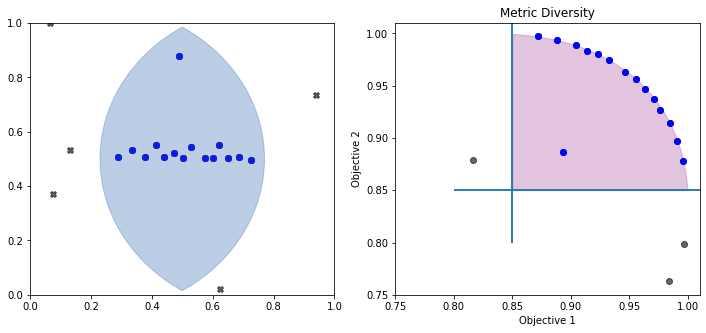

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(mobo_points[:, 0], mobo_points[:, 1], marker='X', color='black', alpha=0.6)
axes[0].scatter(mobo_points[mobo_feasible_inds, 0], mobo_points[mobo_feasible_inds, 1], marker='o', color='blue')
axes[0].fill(
  numpy.append(x_c1_p[sorted_idx], x_c2_p),
  numpy.append(y_c1_p[sorted_idx], y_c2_p),
  color=sigopt_blue, 
  alpha=0.3
)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
axes[1].scatter(mobo_values[:, 0], mobo_values[:, 1], color="black", alpha=0.6)
axes[1].scatter(mobo_values[mobo_feasible_inds, 0], mobo_values[mobo_feasible_inds, 1], marker='o', color='blue')
axes[1].vlines([threshold] * 2, 0.8, 1.01)
axes[1].hlines([threshold] * 2, 0.8, 1.01)
axes[1].set_xlim([0.75, 1.01])
axes[1].set_ylim([0.75, 1.01])
plt.title("Metric Diversity")
plt.show()

In [16]:
qr = MOBOService(
  parameters=parameters,
  constraints=constraints,
    num_init_points=20,
)
for i in range(20):
  suggestion = qr.create_suggestion()
  values = objective_function(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  qr.create_observation(observation)

suggestions: {'id': 20, 'x0': 0.029959168285131454, 'x1': 0.6879802942276001}
obj: [0.9683852961043559, 0.7304096507939412]
suggestions: {'id': 19, 'x0': 0.858401894569397, 'x1': 0.1205674260854721}
obj: [0.7492136669952563, 0.9289596919824825]
suggestions: {'id': 18, 'x0': 0.5924006700515747, 'x1': 0.8074802756309509}
obj: [0.8831491296571454, 0.933493946413833]
suggestions: {'id': 17, 'x0': 0.2960939109325409, 'x1': 0.3768004775047302}
obj: [0.9878681110049123, 0.8741094044265245]
suggestions: {'id': 16, 'x0': 0.2757297158241272, 'x1': 0.7739337086677551}
obj: [0.9604173654695943, 0.8394994112230778]
suggestions: {'id': 15, 'x0': 0.6054290533065796, 'x1': 0.4097059369087219}
obj: [0.9173530571749766, 0.9772571718155709]
suggestions: {'id': 14, 'x0': 0.8382996320724487, 'x1': 0.7208400964736938}
obj: [0.7960459375944382, 0.975194242242501]
suggestions: {'id': 13, 'x0': 0.042748499661684036, 'x1': 0.08706679940223694}
obj: [0.9069926511617863, 0.6893736609000823]
suggestions: {'id': 12

In [17]:
qr_points = numpy.array(qr.get_points())
qr_values = numpy.array(qr.get_values())
qr_feasible_inds = numpy.array(qr.get_feasible_indices())

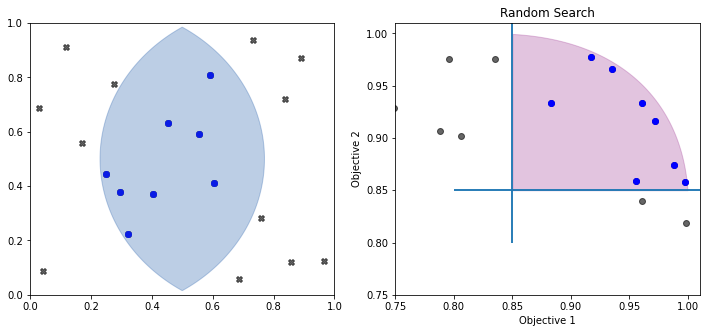

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(qr_points[:, 0], qr_points[:, 1], marker='X', color='black', alpha=0.6)
axes[0].scatter(qr_points[qr_feasible_inds, 0], qr_points[qr_feasible_inds, 1], marker='o', color='blue')
axes[0].fill(
  numpy.append(x_c1_p[sorted_idx], x_c2_p),
  numpy.append(y_c1_p[sorted_idx], y_c2_p),
  color=sigopt_blue, 
  alpha=0.3
)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
axes[1].scatter(qr_values[:, 0], qr_values[:, 1], color="black", alpha=0.6)
axes[1].scatter(qr_values[qr_feasible_inds, 0], qr_values[qr_feasible_inds, 1], marker='o', color='blue')
axes[1].vlines([threshold] * 2, 0.8, 1.01)
axes[1].hlines([threshold] * 2, 0.8, 1.01)
axes[1].set_xlim([0.75, 1.01])
axes[1].set_ylim([0.75, 1.01])
plt.title("Random Search")
plt.show()

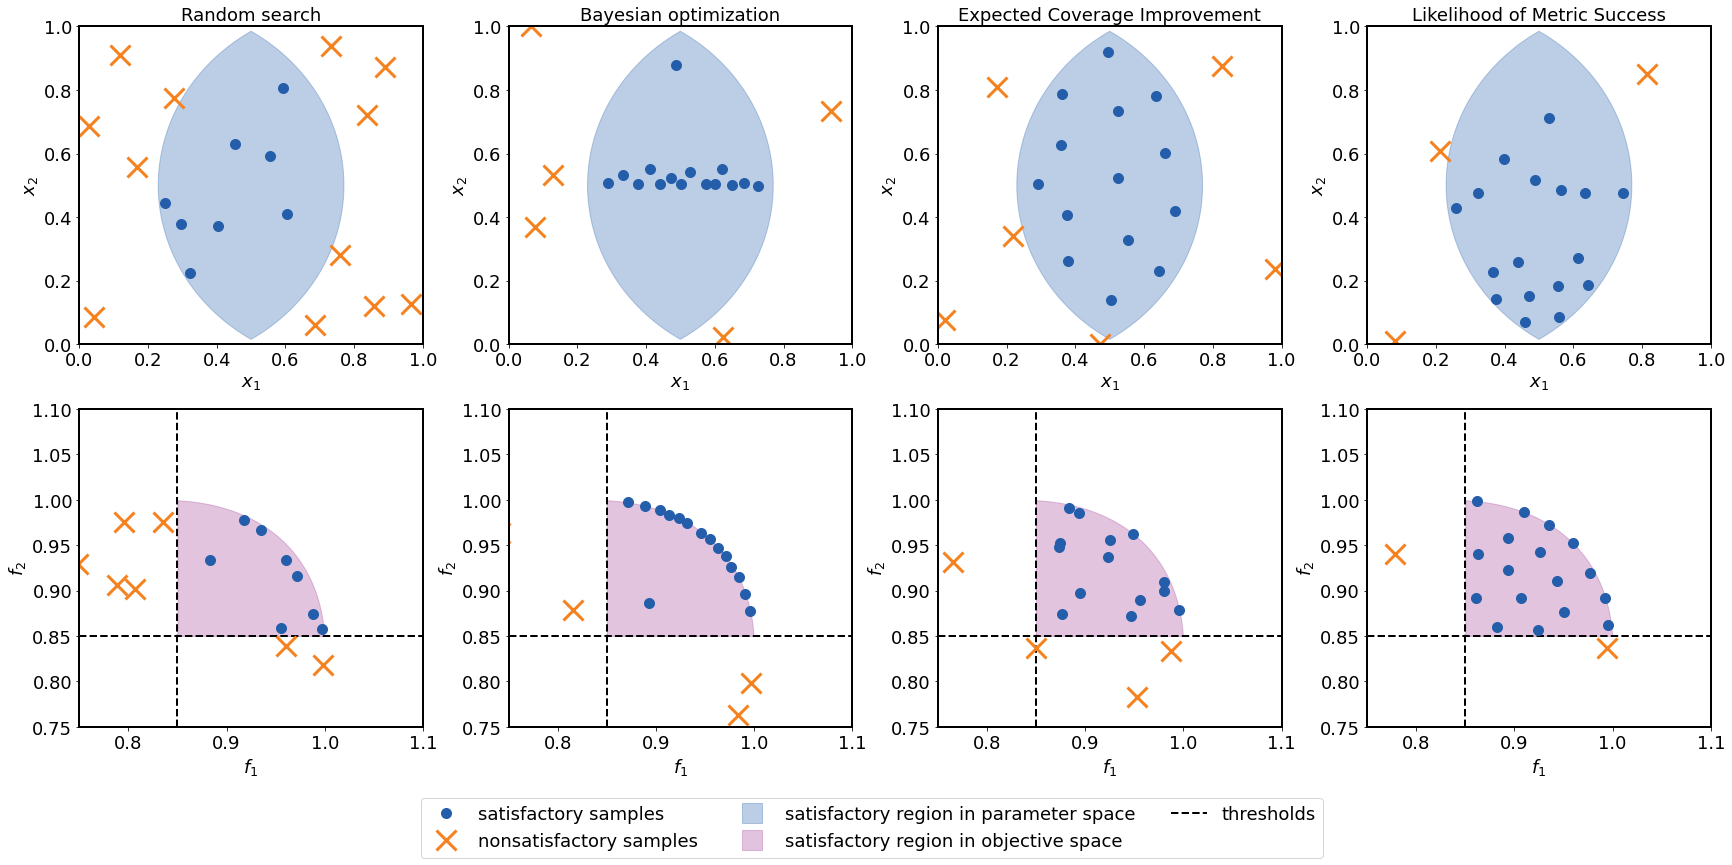

In [32]:
import itertools
from matplotlib.lines import Line2D


linewidth = 2
fontsize = 18
markersize = 20
markeredgewidth = 3
  
  
fig, axes = plt.subplots(2, 4, figsize=(24, 11))
axes[0, 0].set_xlabel("$x_1$", fontsize=fontsize)
axes[0, 0].set_ylabel("$x_2$", fontsize=fontsize)
axes[1, 0].set_xlabel("$f_1$", fontsize=fontsize)
axes[1, 0].set_ylabel("$f_2$", fontsize=fontsize)
for i in range(4):
  axes[0, i].fill(
    numpy.append(x_c1_p[sorted_idx], x_c2_p),
    numpy.append(y_c1_p[sorted_idx], y_c2_p),
    color=sigopt_blue, 
    alpha=0.3
  )
  axes[0, i].set_xlim([0, 1])
  axes[0, i].set_ylim([0, 1])
  axes[0, i].set_xlabel("$x_1$", fontsize=fontsize)
  axes[0, i].set_ylabel("$x_2$", fontsize=fontsize)

  axes[1, i].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
  axes[1, i].vlines(threshold, 0.75, 1.1, linestyle="--", color=sigopt_black, linewidth=linewidth)
  axes[1, i].hlines(threshold, 0.75, 1.1, linestyle="--", color=sigopt_black, linewidth=linewidth)
  axes[1, i].set_xlim([0.75, 1.1])
  axes[1, i].set_ylim([0.75, 1.1])
  axes[1, i].set_xlabel("$f_1$", fontsize=fontsize)
  axes[1, i].set_ylabel("$f_2$", fontsize=fontsize)

for i, j in itertools.product(range(2), range(4)):
  axes[i, j].xaxis.set_tick_params(labelsize=fontsize)
  axes[i, j].yaxis.set_tick_params(labelsize=fontsize)
  for axis in ['top','bottom','left','right']:
    axes[i, j].spines[axis].set_linewidth(linewidth)


axes[0, 1].set_title("Bayesian optimization", fontsize=fontsize)
axes[0, 1].plot(mobo_points[mobo_feasible_inds, 0], mobo_points[mobo_feasible_inds, 1], '.', color=sigopt_blue, markersize=markersize)
axes[0, 1].plot(mobo_points[~mobo_feasible_inds, 0], mobo_points[~mobo_feasible_inds, 1], 'x', color=sigopt_orange, markersize=markersize, mew=markeredgewidth)
axes[1, 1].plot(mobo_values[mobo_feasible_inds, 0], mobo_values[mobo_feasible_inds, 1], '.', color=sigopt_blue, markersize=markersize)
axes[1, 1].plot(mobo_values[~mobo_feasible_inds, 0], mobo_values[~mobo_feasible_inds, 1], 'x', color=sigopt_orange, markersize=markersize, mew=markeredgewidth)


axes[0, 3].plot(emcs_points[emcs_feasible_inds, 0], emcs_points[emcs_feasible_inds, 1], '.', color=sigopt_blue, markersize=markersize)
axes[0, 3].plot(emcs_points[~emcs_feasible_inds, 0], emcs_points[~emcs_feasible_inds, 1], 'x', color=sigopt_orange, markersize=markersize, mew=markeredgewidth)
axes[0, 3].set_title("Likelihood of Metric Success", fontsize=fontsize)
axes[1, 3].plot(emcs_values[emcs_feasible_inds, 0], emcs_values[emcs_feasible_inds, 1], '.', color=sigopt_blue, markersize=markersize)
axes[1, 3].plot(emcs_values[~emcs_feasible_inds, 0], emcs_values[~emcs_feasible_inds, 1], 'x', color=sigopt_orange, markersize=markersize, mew=markeredgewidth)



axes[0, 2].plot(cas_points[cas_feasible_inds, 0], cas_points[cas_feasible_inds, 1], '.', color=sigopt_blue, markersize=markersize)
axes[0, 2].plot(cas_points[~cas_feasible_inds, 0], cas_points[~cas_feasible_inds, 1], 'x', color=sigopt_orange, markersize=markersize, mew=markeredgewidth)
axes[0, 2].set_title("Expected Coverage Improvement", fontsize=fontsize)
axes[1, 2].plot(cas_values[cas_feasible_inds, 0], cas_values[cas_feasible_inds, 1], '.', color=sigopt_blue, markersize=markersize)
axes[1, 2].plot(cas_values[~cas_feasible_inds, 0], cas_values[~cas_feasible_inds, 1], 'x', color=sigopt_orange, markersize=markersize, mew=markeredgewidth)



axes[0, 0].plot(qr_points[qr_feasible_inds, 0], qr_points[qr_feasible_inds, 1], '.', color=sigopt_blue, markersize=markersize)
axes[0, 0].plot(qr_points[~qr_feasible_inds, 0], qr_points[~qr_feasible_inds, 1], 'x', color=sigopt_orange, markersize=markersize, mew=markeredgewidth)
axes[0, 0].set_title("Random search", fontsize=fontsize)
axes[1, 0].plot(qr_values[qr_feasible_inds, 0], qr_values[qr_feasible_inds, 1], '.', color=sigopt_blue, markersize=markersize)
axes[1, 0].plot(qr_values[~qr_feasible_inds, 0], qr_values[~qr_feasible_inds, 1], 'x', color=sigopt_orange, markersize=markersize, mew=markeredgewidth)


    
  
lgd = fig.legend(
  [
    Line2D([0], [0], color=sigopt_blue, marker=".", linestyle="none", markersize=markersize),
    Line2D([0], [0], color=sigopt_orange, marker="x", linestyle="none", markersize=markersize, mew=markeredgewidth),
    Line2D([0], [0], color=sigopt_blue, marker="s", linestyle="none", markersize=markersize, alpha=0.3),
    Line2D([0], [0], color=sigopt_magenta, marker="s", linestyle="none", markersize=markersize, alpha=0.3),
    Line2D([0], [0], color=sigopt_black, linestyle="--", lw=linewidth),
  ], 
  [
    "satisfactory samples",
    "nonsatisfactory samples",
    "satisfactory region in parameter space",
    "satisfactory region in objective space",
    "thresholds",
  ], 
  ncol=3,
  bbox_to_anchor=(0, -0.1, 1, 1), 
  loc='lower center', 
  fontsize=fontsize,
)
plt.tight_layout()
fig.savefig("wintersim_search_comparison.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)
plt.show()